In [30]:
import base64
import json
import os
from tqdm import tqdm
import datetime
import pytz

timestamps = []
time_differences = []

def save_base64_images(file_path, output_base_dir):
    img_counter = 0
    # Create the base output directory if it doesn't exist
    os.makedirs(output_base_dir, exist_ok=True)
    
    previous_michigan_time = None

    with open(file_path, 'r') as file:
        for line in tqdm(file, desc=f"Processing {file_path}"):
            try:
                data = json.loads(line)
                sensor_name = data.get("sensor_name")
                image_base64 = data.get("image")
                timestamp = data.get("event_timestamp")

                if sensor_name and image_base64 and timestamp:
                    img_counter += 1
                    # Create the sensor-specific directory if it doesn't exist
                    sensor_dir = os.path.join(output_base_dir, sensor_name)
                    os.makedirs(sensor_dir, exist_ok=True)
                    
                    # Decode the base64 image data
                    image_data = base64.b64decode(image_base64)
                    
                    # Get timestamps in UTC and Michigan time
                    utc_time = datetime.datetime.fromtimestamp(timestamp, tz=datetime.timezone.utc)
                    michigan_tz = pytz.timezone('America/Detroit')
                    michigan_time = utc_time.astimezone(michigan_tz)
                    timestamps.append(michigan_time)

                    formatted_time = michigan_time.strftime('%Y%m%d-%H%M%S-%f')[:-3]
                    
                    previous_michigan_time = michigan_time

                    image_filename = f"{sensor_name}_{formatted_time}.jpg"
                    output_path = os.path.join(sensor_dir, image_filename)
                    
                    # Save the decoded image data as a JPEG
                    with open(output_path, 'wb') as image_file:
                        image_file.write(image_data)
                else:
                    print(f"Missing sensor_name or image data in entry: {data}")
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
    
    return img_counter

def calculate_time_differences():
    timestamps.sort()
    previous_michigan_time = None
    for timestamp in timestamps:
        if previous_michigan_time is not None:
            time_difference = (timestamp - previous_michigan_time).total_seconds()
            time_differences.append(time_difference)
        previous_michigan_time = timestamp


data_path = "/media/dbogdoll/Datasets/aws_s3_playground/"
files = os.listdir(data_path)
output_path = os.path.join(data_path, "decoded")

img_counter = 0
for file in tqdm(files, desc="Processing files"):
    if "sip" in file:
        file_path = os.path.join(data_path, file)
        processed_imgs = save_base64_images(file_path, output_path)
        img_counter += processed_imgs

calculate_time_differences()

print(f"Processed {img_counter} images")

Processing /media/dbogdoll/Datasets/aws_s3_playground/sip-data-stream2-delivery-stream-2-2024-04-12-16-42-27-386fe54a-5fdd-3d54-a8c7-9c1c77d5caaa: 1521it [00:00, 5937.92it/s]
Processing /media/dbogdoll/Datasets/aws_s3_playground/sip-data-stream2-delivery-stream-2-2024-04-12-16-53-44-ce3b91a6-0742-353e-8768-298175483867: 46it [00:00, 2802.86it/s]
Processing /media/dbogdoll/Datasets/aws_s3_playground/sip-data-stream2-delivery-stream-2-2024-04-12-16-48-03-07b5335b-62af-3a60-97c9-b3eda0ce6210: 1572it [00:00, 6001.61it/s]
Processing /media/dbogdoll/Datasets/aws_s3_playground/sip-data-stream2-delivery-stream-2-2024-04-12-16-14-20-d32e18bc-624e-3df8-bac3-fc071142a522: 1390it [00:00, 6322.67it/s]
Processing /media/dbogdoll/Datasets/aws_s3_playground/sip-data-stream2-delivery-stream-2-2024-04-12-16-48-03-4bdff00d-135a-38ce-9f49-b2404db0e1ad: 127it [00:00, 4490.01it/s]
Processing /media/dbogdoll/Datasets/aws_s3_playground/sip-data-stream2-delivery-stream-2-2024-04-12-16-25-36-1b0621a6-479c-3c30-

Processed 13177 images


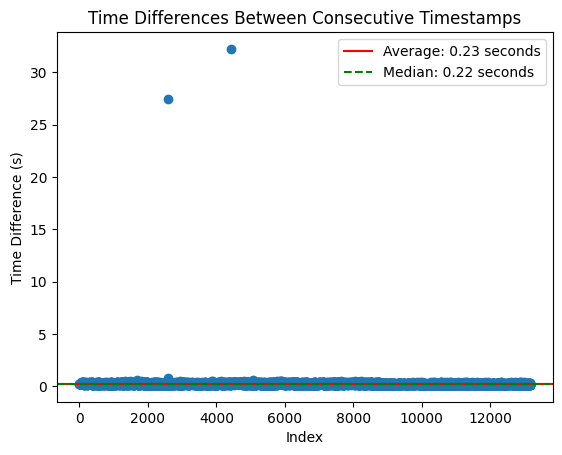

In [29]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(time_differences))
plt.scatter(x, time_differences)

# Calculate average and median
average_time_diff = np.mean(time_differences)
median_time_diff = np.median(time_differences)

plt.axhline(y=average_time_diff, color='r', linestyle='-', label=f'Average: {average_time_diff:.2f} seconds')
plt.axhline(y=median_time_diff, color='g', linestyle='--', label=f'Median: {median_time_diff:.2f} seconds')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Time Difference (s)')
plt.title('Time Differences Between Consecutive Timestamps')
plt.legend()

# Show the plot
plt.show()